## NN datos balanceados oversampling



(4781, 9000)


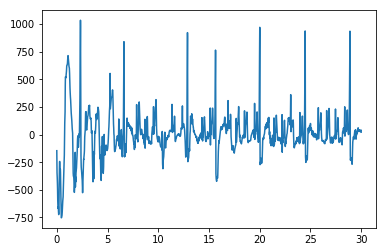

In [1]:
#load data
#load data
%matplotlib inline
import matplotlib.pyplot as plt
#load data
import numpy as np

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

#Decimamos

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

fs = 300. #Hz
t = np.arange(len(X_train[0]))/fs
plt.plot(t,X_train[0,:])

#Es probable que tengamos un problema mal condicionado: vamos a realizar un submuestreo de la señal a 50 muestras por segundo
from scipy import signal

decimate = False

if decimate:
    freq = fs/10#Hz
    print(freq)
    secs = len(X_train[200])/fs
    samps = int(secs*freq)
    c = 0
    X_new = np.zeros((X_train.shape[0],samps))
    X_new_test = np.zeros((X_test.shape[0],samps))
    for x,x_test in zip(X_train,X_test):
        X_new[c,:] = signal.decimate(x,10,ftype = 'fir')
        X_new_test[c,:] = signal.decimate(x_test,10,ftype = 'fir')
    
        c += 1
    
    t = np.arange(len(X_new[200]))/freq
    plt.plot(t,X_new[200,:])
    print(len(X_new[0]))

    X_train = X_new.copy()
    X_test = X_new_test.copy()
    
print(X_train.shape)

In [2]:
from sklearn.preprocessing import StandardScaler

#normalizamos train
my_scaler = StandardScaler()

X_train_n = my_scaler.fit_transform(X_train)

/home/miguelangel/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [3]:
#Vamos a probar balanceando con under sampling y over sampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_sample(X_train_n, y_train)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_sample(X_train_n, y_train)

print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_resampled")
print(sorted(Counter(y_resampled).items()))

print("y_oversampled")
print(sorted(Counter(y_oversampled).items()))


print("y_train")
print(sorted(Counter(y_train).items()))

"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_resampled
[(0, 100), (1, 100), (2, 100), (3, 100)]
y_oversampled
[(0, 2942), (1, 2942), (2, 2942), (3, 2942)]
y_train
[(0, 2942), (1, 399), (2, 1340), (3, 100)]


In [4]:
#función para crear un modelo de un número determinado de capas

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import initializers
from keras.layers.normalization import BatchNormalization
import keras


#f1 score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_model(N,n_hidd = [2,2,2],p = 0):
    """
    Modelo de red neuronal. 
    
    N: number of input featurs
    n_hidd indica la arquitectura del modelo: n_cols = número de capas, value for eahc col, the number of hidden
    units
    """
    
    model = Sequential()
    
    #input layer
    model.add(Dense(n_hidd[0],input_dim = N,activation = 'relu'))
    model.add(BatchNormalization())
    
    #hidden layers
    for n_h in n_hidd[1:]:
        model.add(Dense(n_h,activation='relu',kernel_initializer=initializers.he_normal(seed=None)))
        model.add(BatchNormalization())  
        model.add(Dropout(p))
        
    #output layer
    model.add(Dense(4,activation = 'softmax'))
   

    opt =keras.optimizers.Adam(lr = 4e-2)
    #compile model
    model.compile(loss='categorical_crossentropy',optimizer = opt,metrics = ['accuracy',f1])
    return model

/home/miguelangel/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
## dev and train split

#Split data into dev and trin
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(n_splits = 1,test_size = 0.20)

#WARNING que volvemos a llamar train
for train, dev in skf.split(X_oversampled,y_oversampled):
    X_train, X_dev = X_oversampled[train], X_oversampled[dev]
    y_train, y_dev = y_oversampled[train], y_oversampled[dev]
    
print(X_train.shape)
print(X_dev.shape)

(9414, 9000)
(2354, 9000)


In [6]:
#Entrenamos el modelo 

N = X_train.shape[1]#number of features
#n_h = [int(N/2),int(N/4),int(N/8),int(N/16),int(N/32)]
n_h = [6,3,3]
print(n_h)
print(N)
prob_dropout = 0.5
model = KerasClassifier(build_fn = create_model,N=N,n_hidd=n_h, p = prob_dropout,epochs = 150, batch_size = 100, verbose = 1)

history = model.fit(X_train,y_train)

[4500, 2250, 1125, 562, 281]
9000
Epoch 1/150
9414/9414 [==============================] - 185s 20ms/step - loss: 1.8470 - acc: 0.3360 - f1: 0.2460
Epoch 2/150
9414/9414 [==============================] - 185s 20ms/step - loss: 1.3172 - acc: 0.3665 - f1: 0.1825
Epoch 3/150
9414/9414 [==============================] - 184s 20ms/step - loss: 1.2838 - acc: 0.3638 - f1: 0.1986
Epoch 4/150
9414/9414 [==============================] - 183s 19ms/step - loss: 1.2592 - acc: 0.3866 - f1: 0.2345
Epoch 5/150
9414/9414 [==============================] - 186s 20ms/step - loss: 1.1981 - acc: 0.4186 - f1: 0.2900
Epoch 6/150
9414/9414 [==============================] - 184s 20ms/step - loss: 1.0575 - acc: 0.4725 - f1: 0.3942
Epoch 7/150
9414/9414 [==============================] - 186s 20ms/step - loss: 0.9653 - acc: 0.5203 - f1: 0.4637
Epoch 8/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.8147 - acc: 0.6243 - f1: 0.5991
Epoch 9/150
9414/9414 [==============================]

9414/9414 [==============================] - 183s 19ms/step - loss: 0.5975 - acc: 0.7348 - f1: 0.7349
Epoch 73/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.5036 - acc: 0.7330 - f1: 0.7323
Epoch 74/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.5365 - acc: 0.7323 - f1: 0.7317
Epoch 75/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.5767 - acc: 0.7282 - f1: 0.7280
Epoch 76/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.4671 - acc: 0.7373 - f1: 0.7357
Epoch 77/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.4561 - acc: 0.7352 - f1: 0.7345
Epoch 78/150
9414/9414 [==============================] - 184s 20ms/step - loss: 0.4400 - acc: 0.7401 - f1: 0.7386
Epoch 79/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.4917 - acc: 0.7373 - f1: 0.7369
Epoch 80/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.5178 - acc

Epoch 143/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.5245 - acc: 0.7372 - f1: 0.7368
Epoch 144/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.4582 - acc: 0.7464 - f1: 0.7461
Epoch 145/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.4194 - acc: 0.7480 - f1: 0.7480
Epoch 146/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.4069 - acc: 0.7477 - f1: 0.7472
Epoch 147/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.4115 - acc: 0.7431 - f1: 0.7429
Epoch 148/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.4050 - acc: 0.7495 - f1: 0.7487
Epoch 149/150
9414/9414 [==============================] - 183s 19ms/step - loss: 0.4737 - acc: 0.7395 - f1: 0.7395
Epoch 150/150
9414/9414 [==============================] - 184s 19ms/step - loss: 0.4718 - acc: 0.7386 - f1: 0.7386


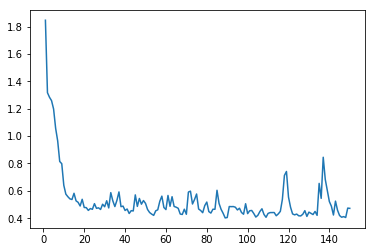

In [7]:
#plot loss
loss = history.history['loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss)


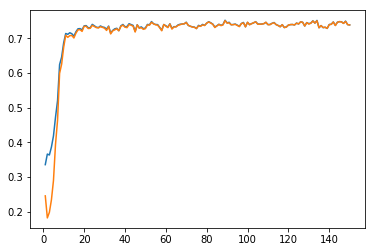

In [8]:
#plot accuracy and f1
acc = history.history['acc']
f1 = history.history['f1']

epochs = range(1,len(loss)+1)

plt.plot(epochs,acc)
plt.plot(epochs,f1)


In [9]:
from sklearn import metrics
#training and dev prediction
y_hat_train = model.predict(X_train)

target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_train, y_hat_train)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_train, y_hat_train,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_train, y_hat_train))

9414/9414 [==============================] - 44s 5ms/step
accuracy:   0.749
classification report:
             precision    recall  f1-score   support

     Normal       0.00      0.00      0.00      2353
         AF       1.00      1.00      1.00      2354
      Other       0.50      1.00      0.67      2353
      Noise       1.00      1.00      1.00      2354

avg / total       0.62      0.75      0.67      9414

confusion matrix:
[[   0    2 2350    1]
 [   0 2349    5    0]
 [   0    0 2351    2]
 [   0    0    0 2354]]


/home/miguelangel/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
from sklearn import metrics
#training and dev prediction
y_hat_dev = model.predict(X_dev)

target_names = ['Normal','AF','Other','Noise']



score = metrics.accuracy_score(y_dev, y_hat_dev)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_dev, y_hat_dev,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_dev, y_hat_dev))

2354/2354 [==============================] - 11s 5ms/step
accuracy:   0.745
classification report:
             precision    recall  f1-score   support

     Normal       0.00      0.00      0.00       589
         AF       0.98      0.99      0.98       588
      Other       0.50      0.99      0.66       589
      Noise       0.99      1.00      1.00       588

avg / total       0.62      0.75      0.66      2354

confusion matrix:
[[  0   8 579   2]
 [  0 583   5   0]
 [  0   5 583   1]
 [  0   0   0 588]]
